<a href="https://colab.research.google.com/github/MartinaWestrik/Eurosat-Neural-Networks/blob/main/FINAL_AugV2_VGG16_Eurosat_ladeni_lr_early.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importy
import os
import random

import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt  # Vizualizace
import seaborn as sns  # Matice záměn
from sklearn.metrics import confusion_matrix, classification_report  # Klasifikační metriky

import kagglehub
from google.colab import files

In [2]:
# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.04G/2.04G [01:32<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [3]:
# 1. Nastavení správné cesty ke složce s obrázky
DATASET_PATH = "/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6"
print("Dataset obsahuje:", os.listdir(DATASET_PATH))

Dataset obsahuje: ['EuroSAT', 'EuroSATallBands']


In [4]:
# 2. Cesta ke složkám s obrázky
data_dir = os.path.join(DATASET_PATH, "EuroSAT")

# 3. Parametry datasetu
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_CLASSES = 10

In [5]:
# 4. Načtení datasetu a příprava dat pomocí ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # mírná rotace – satelitní úhly se mohou lišit
    zoom_range=0.1,            # mírné přiblížení/oddálení
    horizontal_flip=True,      # satelitní záběry jsou symetrické – horizontální flip dává smysl
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,             # lépe pro učení
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=False,            # zachovat pro správné vyhodnocení
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [6]:
# 5. Načtení předtrénovaného modelu VGG16 bez klasifikačních vrstev
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# 6. Zamrznutí konvolučních vrstev (feature extractor)
for layer in base_model.layers:
    layer.trainable = True

# 7. Přidání vlastní klasifikační hlavy
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Uložení do 'outputs'

# 8. Sestavení modelu
model = Model(inputs=base_model.input, outputs=outputs)  # Použití 'outputs'

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# 9. Kompilace modelu
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# 10. Výpis struktury modelu
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,978,250 (57.14 MB)

 Trainable params: 14,978,250 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 11. Definování EarlyStopping callbacku
early_stopping = EarlyStopping(
    monitor="val_accuracy",    # Sledujeme validační presnost
    patience=10,           # Po 10 epochách bez zlepšení ukončí trénování
    min_delta=0.003,
    restore_best_weights=True # Vrátí nejlepší model
)

In [9]:
# 12. Definování callbacku pro ukládání nejlepšího modelu
checkpoint = ModelCheckpoint(
    filepath="FINAL_best.keras",  # Uložení modelu do souboru
    monitor="val_accuracy",       # Sleduje nejlepší přesnost na validačních datech
    save_best_only=True,          # Uloží pouze nejlepší model
    save_weights_only=False,      # Uloží model včetně architektury (ne jen váhy)
    verbose=1                     # Zobrazí info o ukládání
)

In [10]:
# 13. Trénování modelu
EPOCHS = 100
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator,verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6698 - loss: 0.9863
Epoch 1: val_accuracy improved from -inf to 0.92630, saving model to V5_best_model.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.6700 - loss: 0.9857 - val_accuracy: 0.9263 - val_loss: 0.2261
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9191 - loss: 0.2838
Epoch 2: val_accuracy improved from 0.92630 to 0.93759, saving model to V5_best_model.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 72s 95ms/step - accuracy: 0.9191 - loss: 0.2837 - val_accuracy: 0.9376 - val_loss: 0.1964
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9435 - loss: 0.1973
Epoch 3: val_accuracy did not improve from 0.93759
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 89ms/step - accuracy: 0.9435 - loss: 0.1973 - val_accuracy: 0.8969 - val_loss: 0.3596
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9488 - loss: 0.1693
Epoch 4: val_accuracy improved from 0.93759 to 0.96519, saving model to

In [11]:
# 14. Vyhodnocení modelu na validační sadě
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validační přesnost: {val_acc:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9758 - loss: 0.0821
Validační přesnost: 0.9741


In [12]:
# 15. Funkce pro predikci TOP-2 tříd u nového obrázku
def predict_top_2(image_path, model, class_indices):
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]

    top_2_indices = np.argsort(predictions)[-2:][::-1]
    top_2_classes = [list(class_indices.keys())[list(class_indices.values()).index(i)] for i in top_2_indices]
    top_2_probs = [predictions[i] for i in top_2_indices]

    return list(zip(top_2_classes, top_2_probs))

In [13]:
# 16. Získání jmen tříd
class_indices = train_generator.class_indices

In [14]:
# 17. Test predikce na náhodném obrázku z datasetu
random_image = random.choice(train_generator.filepaths)

top_2_predictions = predict_top_2(random_image, model, class_indices)
print(f"Top-2 predikované třídy pro obrázek: {top_2_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top-2 predikované třídy pro obrázek: [('River', np.float32(1.0)), ('Highway', np.float32(6.1318635e-09))]


In [1]:
# 18. Vizualizace trénování – Graf přesnosti a ztráty
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graf ztráty (Loss)
    axs[0].plot(history.history['loss'], label='Trénovací ztráta')
    axs[0].plot(history.history['val_loss'], label='Validační ztráta')
    axs[0].set_title('Vývoj ztráty (Loss)')
    axs[0].set_xlabel('Epochy')
    axs[0].set_ylabel('Ztráta')
    axs[0].legend()

    # Graf přesnosti (Accuracy)
    axs[1].plot(history.history['accuracy'], label='Trénovací přesnost')
    axs[1].plot(history.history['val_accuracy'], label='Validační přesnost')
    axs[1].set_title('Vývoj přesnosti (Accuracy)')
    axs[1].set_xlabel('Epochy')
    axs[1].set_ylabel('Přesnost')
    axs[1].legend()

    plt.show()

In [16]:
# from tensorflow.keras.models import load_model

# Načtení nejlepšího uloženého modelu
# model = load_model("best_model.keras")

# Ověření struktury modelu
# best_model.summary()

169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step


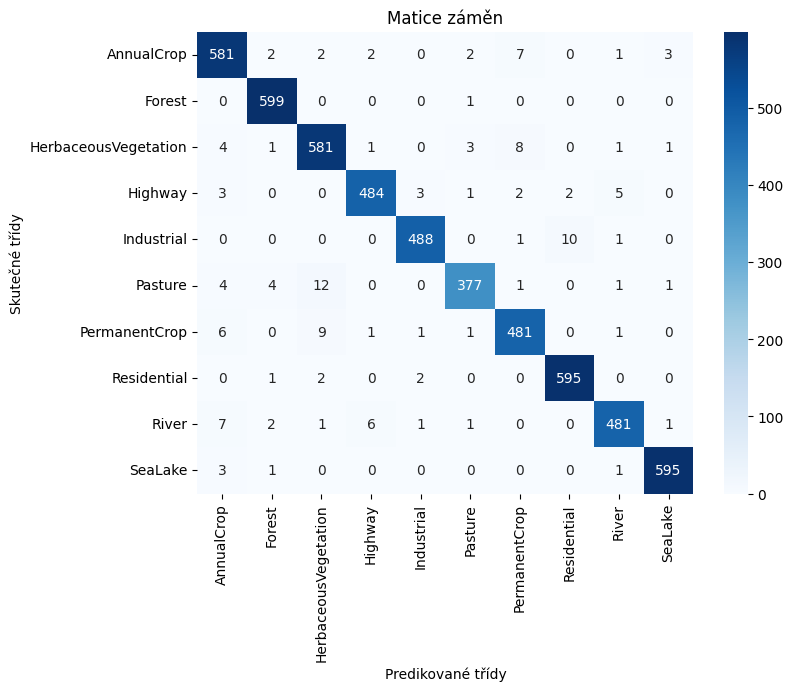


Klasifikační report:
                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.97      0.96       600
              Forest       0.98      1.00      0.99       600
HerbaceousVegetation       0.96      0.97      0.96       600
             Highway       0.98      0.97      0.97       500
          Industrial       0.99      0.98      0.98       500
             Pasture       0.98      0.94      0.96       400
       PermanentCrop       0.96      0.96      0.96       500
         Residential       0.98      0.99      0.99       600
               River       0.98      0.96      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



In [17]:
# Získání skutečných a predikovaných hodnot
y_true = val_generator.classes  # Skutečné třídy
y_pred_probs = model.predict(val_generator)  # Predikované pravděpodobnosti
y_pred = y_pred_probs.argmax(axis=1)  # Nejpravděpodobnější třídy

# Matice záměn
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predikované třídy")
plt.ylabel("Skutečné třídy")
plt.title("Matice záměn")
plt.show()

# Výpis klasifikační zprávy
print("\nKlasifikační report:")
print(classification_report(y_true, y_pred, target_names=labels))

In [18]:
# 19. Funkce pro vykreslení matice záměn
def plot_confusion_matrix(model, val_generator):
    # Získání skutečných a predikovaných hodnot
    y_true = val_generator.classes  # Skutečné třídy
    y_pred_probs = model.predict(val_generator)  # Predikované pravděpodobnosti
    y_pred = y_pred_probs.argmax(axis=1)  # Nejpravděpodobnější třídy

    # Matice záměn
    cm = confusion_matrix(y_true, y_pred)
    labels = list(val_generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predikované třídy")
    plt.ylabel("Skutečné třídy")
    plt.title("Matice záměn")
    plt.show()

    # Výpis klasifikační zprávy
    print("\nKlasifikační report:")
    print(classification_report(y_true, y_pred, target_names=labels))

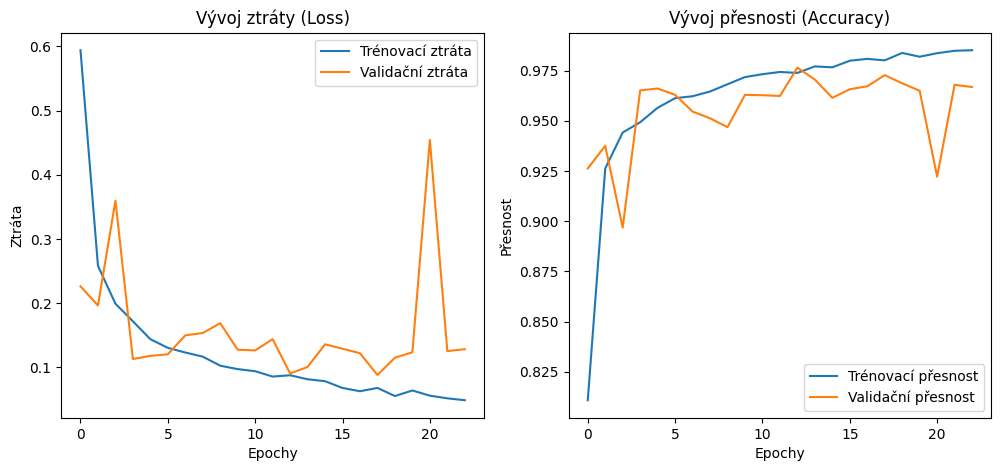

169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step


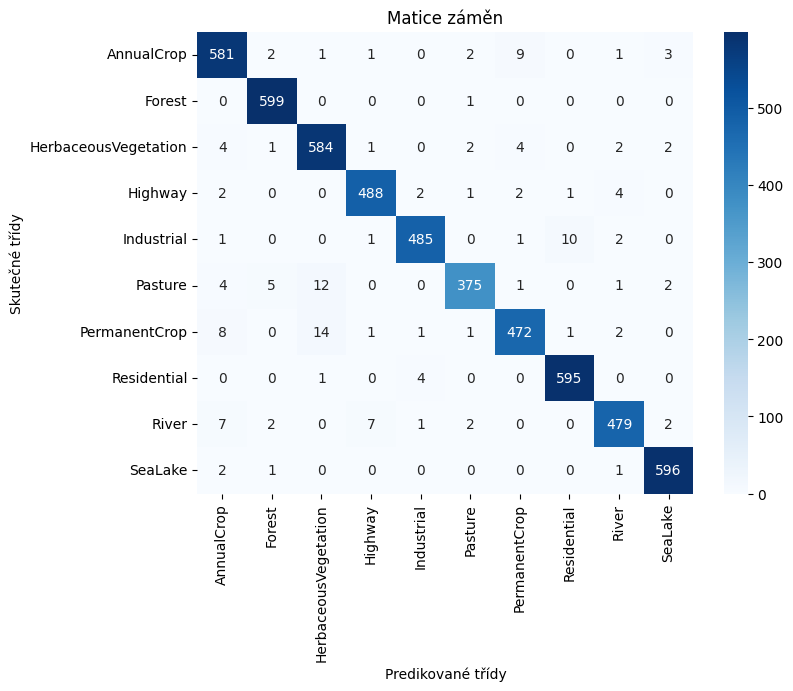


Klasifikační report:
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.97      0.96       600
              Forest       0.98      1.00      0.99       600
HerbaceousVegetation       0.95      0.97      0.96       600
             Highway       0.98      0.98      0.98       500
          Industrial       0.98      0.97      0.98       500
             Pasture       0.98      0.94      0.96       400
       PermanentCrop       0.97      0.94      0.95       500
         Residential       0.98      0.99      0.99       600
               River       0.97      0.96      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



In [19]:
# 20. Spuštění vizualizací
plot_training_history(history)  # Graf přesnosti a ztráty
plot_confusion_matrix(model, val_generator)  # Matice záměn

In [20]:
# Stáhnutí modelu do počítače
files.download("FINAL_best.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Po dokončení trénování můžeš model kdykoliv načíst takto:

# from tensorflow.keras.models import load_model

# Načtení nejlepšího uloženého modelu
# best_model = load_model("best_model.keras")

# Ověření struktury modelu
# best_model.summary()

## Vizualizace nejčastějších záměn

In [22]:
# Najčastější záměna - vypíše nejčastější záměny

# Získáme nejčastější chybnou záměnu (ignorujeme diagonálu = správné predikce)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)  # odstraníme správné klasifikace
max_confusion = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)

true_class_idx, pred_class_idx = max_confusion
true_class = labels[true_class_idx]
pred_class = labels[pred_class_idx]

print(f"Nejčastější záměna: Skutečná třída = '{true_class}', Predikovaná = '{pred_class}'")

Nejčastější záměna: Skutečná třída = 'Pasture', Predikovaná = 'HerbaceousVegetation'


In [23]:
# Najde konkrétní obrázky, kde k záměně došlo

# Převedeme generator do DataFrame (pokud máš flow_from_dataframe, použij přímo val_df)
import pandas as pd
val_filenames = val_generator.filenames  # cesty k obrázkům
df_val = pd.DataFrame({
    "filename": val_filenames,
    "true_label": y_true,
    "pred_label": y_pred
})

# Vybereme příklady, kde došlo ke konkrétní záměně
mistakes = df_val[(df_val["true_label"] == true_class_idx) & (df_val["pred_label"] == pred_class_idx)]
mistakes

,filename,true_label,pred_label
2884,Pasture/Pasture_1074.jpg,5,2
2887,Pasture/Pasture_1077.jpg,5,2
2893,Pasture/Pasture_1082.jpg,5,2
2916,Pasture/Pasture_1102.jpg,5,2
2977,Pasture/Pasture_1158.jpg,5,2
2988,Pasture/Pasture_1168.jpg,5,2
3002,Pasture/Pasture_1180.jpg,5,2
3018,Pasture/Pasture_1195.jpg,5,2
3027,Pasture/Pasture_1202.jpg,5,2
3107,Pasture/Pasture_1275.jpg,5,2


<ipython-input-24-5ab75ff2d908>:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


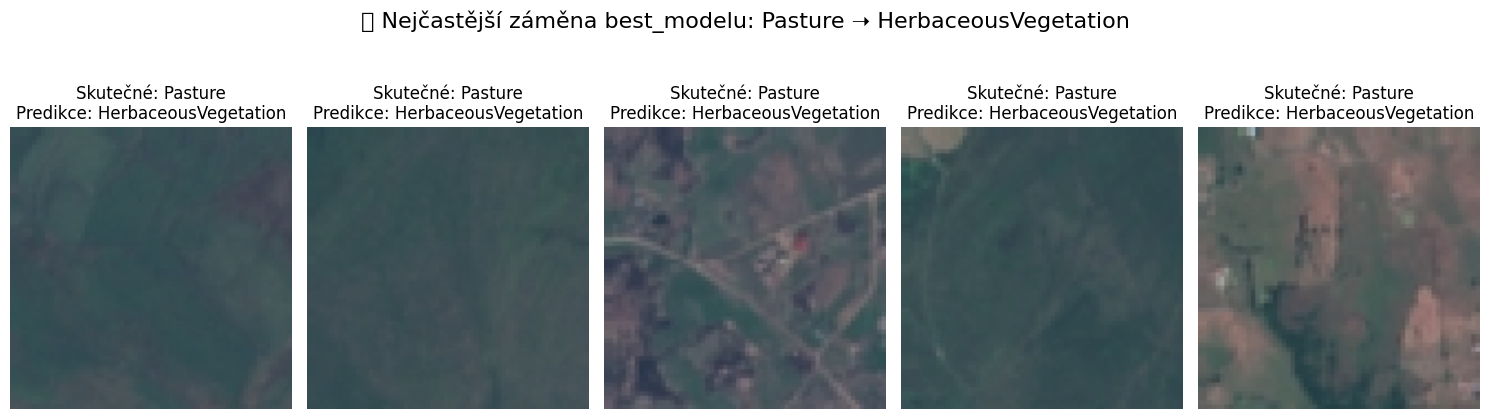

In [24]:
# Vizualizuje 5 příkladů těchto záměn - potřebuje knihovnu!

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Zobrazíme max 5 chybných obrázků
sample_mistakes = mistakes.sample(n=min(5, len(mistakes)))

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample_mistakes.itertuples()):
    img_path = os.path.join(val_generator.directory, row.filename)
    img = load_img(img_path, target_size=(128, 128))  # přizpůsob target_size

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Skutečné: {true_class}\nPredikce: {pred_class}")

plt.suptitle(f"🔍 Nejčastější záměna best_modelu: {true_class} ➝ {pred_class}", fontsize=16)
plt.tight_layout()
plt.show() # Vizualizujeme 5 příkladů těchto záměn